In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))


#LIBRARIES
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pandas as pd

import simpy

from plotnine import *
import plotly.graph_objects as go
import numpy as np


# PYSPARK 
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import StringType, IntegerType, StructType, StructField


In [2]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .master("local[4]") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()

In [3]:
df = spark.read.json('../data/cleaned_dataset')

In [4]:
df.show()

+------------+------------------+--------------------+---------------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+------------+-----------+--------------------+---------------------+-------+--------------+-------+
|acousticness|               age|avg_artist_followers|avg_artist_popularity|danceability|duration_ms|energy|              genres|            id_track|instrumentalness|key|liveness|loudness|mode|popularity_track|release_date|speechiness|sum_artist_followers|sum_artist_popularity|  tempo|time_signature|valence|
+------------+------------------+--------------------+---------------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+------------+-----------+--------------------+---------------------+-------+--------------+-------+
|       0.658|41.821917808219176|              5403.5|             

# Explode on genres and group by genres with average

In [5]:
df = df.withColumn('genre',explode(df.genres).alias("genre"))

In [6]:
df.select('genre').show()

+-------------------+
|              genre|
+-------------------+
|  classic czech pop|
|         czech folk|
|         czech rock|
|           afrobeat|
|            afropop|
|              world|
|  alternative metal|
|   gothenburg metal|
|melodic death metal|
|  melodic metalcore|
|              metal|
|           nu metal|
|swedish death metal|
|      swedish metal|
|          corrosion|
|          dark wave|
|      ethereal wave|
|         gothabilly|
|        gothic rock|
|     brazilian rock|
+-------------------+
only showing top 20 rows



In [7]:
df.count()

2032392

In [8]:
numerical_columns = ['duration_ms','danceability','energy','key','age','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']


In [25]:
dfg = df.groupBy('genre').avg('duration_ms', 'danceability', 'energy', 'key', 'age', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature')

In [26]:
for column in dfg.columns: 
    if column!='genre':
        dfg = dfg.withColumnRenamed(column,column[4:-1])

In [27]:
dfg.printSchema()

root
 |-- genre: string (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- age: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)



 # Agglomerative Clustering

In [12]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [14]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import defaultdict
from scipy.stats.stats import pearsonr

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering


In [28]:
dfp = dfg.toPandas()
dfp

,genre,duration_ms,danceability,energy,key,age,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,singer-songwriter,234273.961846,0.531303,0.416796,5.039608,42.105547,-12.790650,0.049598,0.525870,0.042684,0.212126,0.508226,117.987551,3.861192
1,german metal,270742.303409,0.422507,0.812688,5.723864,27.252684,-7.405195,0.072697,0.044797,0.146675,0.266585,0.373784,125.949850,3.946591
2,anime,241981.625159,0.472649,0.706473,4.959339,16.039174,-7.272574,0.063093,0.262410,0.169810,0.200269,0.470637,127.505146,3.928844
3,french classical piano,190929.922872,0.377282,0.087520,5.348404,61.992444,-25.962604,0.052109,0.985242,0.837186,0.121261,0.235529,103.591138,3.680851
4,poetry,151074.614754,0.673561,0.127916,6.881148,67.896238,-21.130205,0.735375,0.884918,0.016971,0.212004,0.385096,100.583541,3.483607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,british electroacoustic,53560.000000,0.161000,0.491000,4.000000,53.830137,-11.066000,0.040600,0.747000,0.040400,0.225000,0.134000,134.788000,4.000000
4719,japanese chill rap,221073.900000,0.666900,0.609600,3.700000,3.552603,-7.179700,0.198590,0.433060,0.000432,0.136800,0.482100,122.367400,4.000000
4720,aikatsu,264933.000000,0.592000,0.988000,4.000000,9.800000,0.239000,0.152000,0.185000,0.000000,0.060100,0.531000,135.063000,4.000000
4721,bosnian indie,226546.500000,0.760250,0.802750,6.000000,8.128082,-4.840500,0.046900,0.173128,0.000036,0.167550,0.949250,145.002750,4.000000


In [29]:

scaler = preprocessing.MinMaxScaler()
dfs =pd.DataFrame(scaler.fit_transform(dfp[numerical_columns]),columns=numerical_columns,index=dfp['genre'])
dfs

,duration_ms,danceability,energy,key,age,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
genre,,,,,,,,,,,,,
singer-songwriter,0.079558,0.555175,0.419276,0.458146,0.436991,0.659076,0.052044,0.527981,0.042726,0.202497,0.516621,0.604869,0.772238
german metal,0.093323,0.441491,0.817582,0.520351,0.280901,0.780025,0.076282,0.044976,0.146822,0.260961,0.379958,0.645688,0.789318
anime,0.082467,0.493886,0.710719,0.450849,0.163057,0.783004,0.066204,0.263463,0.169980,0.189769,0.478411,0.653661,0.785769
french classical piano,0.063198,0.394234,0.087992,0.486219,0.645983,0.363253,0.054678,0.989199,0.838024,0.104951,0.239420,0.531065,0.736170
poetry,0.048155,0.703826,0.128634,0.625559,0.708027,0.471782,0.771643,0.888472,0.016988,0.202366,0.391457,0.515646,0.696721
...,...,...,...,...,...,...,...,...,...,...,...,...,...
british electroacoustic,0.011349,0.168234,0.493932,0.363636,0.560205,0.697809,0.042602,0.750000,0.040440,0.216318,0.136213,0.690997,0.800000
japanese chill rap,0.074576,0.696865,0.613256,0.336364,0.031835,0.785090,0.208384,0.434798,0.000432,0.121632,0.490064,0.627322,0.800000
aikatsu,0.091130,0.618600,0.993963,0.363636,0.097490,0.951703,0.159496,0.185742,0.000000,0.039291,0.539771,0.692407,0.800000


<AxesSubplot:>

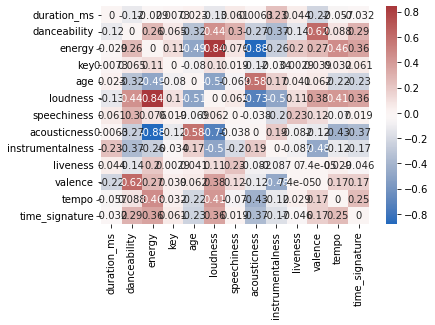

In [30]:
corrMatrix = dfs.corr()
for col in corrMatrix.columns:
    corrMatrix.loc[col,col] = 0

sns.heatmap(corrMatrix,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=corrMatrix.columns, yticklabels=corrMatrix.columns,annot =True)

In [31]:
dfs.drop('energy',axis=1,inplace=True)
numerical_columns.remove('energy')

In [32]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




### COMPLETE EUCLIDEAN

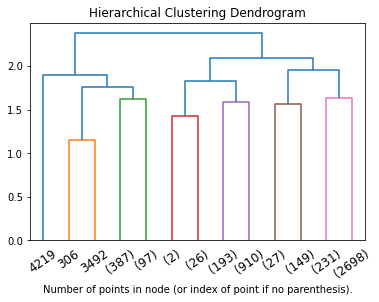

In [33]:

clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete',affinity='euclidean').fit(dfs[numerical_columns])

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xticks(rotation=35)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [34]:

clustering = AgglomerativeClustering(n_clusters=11, linkage='complete',affinity='euclidean').fit(dfs[numerical_columns])
dfp['cluster'] = clustering.labels_
dfp['cluster'].value_counts()

3     2698
0      910
8      387
7      231
4      193
1      149
5       97
2       28
10      27
6        2
9        1
Name: cluster, dtype: int64

### WARD

In [35]:

clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward',affinity='euclidean').fit(dfs[numerical_columns])


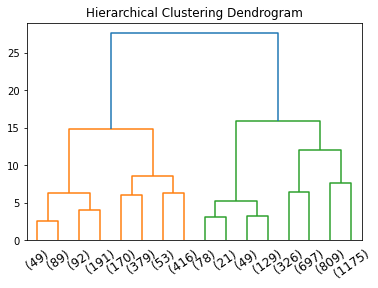

In [39]:

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xticks(rotation=35)
#plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [40]:

clustering = AgglomerativeClustering(n_clusters=8, linkage='ward',affinity='euclidean').fit(dfs[numerical_columns])
dfp['cluster'] = clustering.labels_
dfp['cluster'].value_counts()

3    1175
6     809
4     697
2     549
1     469
0     421
7     326
5     277
Name: cluster, dtype: int64

In [45]:
for c in dfp.cluster.unique():
    print('__________\n',c,'\n_____________')
    print(dfp.loc[dfp.cluster==c,'genre'].value_counts(),end='\n\n')

__________
 3 
_____________
singer-songwriter             1
brega romantico               1
dutch cabaret                 1
nouvelle chanson francaise    1
trondersk musikk              1
                             ..
cumbia uruguaya               1
rock quebecois                1
festigal                      1
musica mocambicana            1
aikatsu                       1
Name: genre, Length: 1175, dtype: int64

__________
 4 
_____________
german metal              1
traditional ska           1
christian rock            1
groove metal              1
norwegian punk rock       1
                         ..
indie canario             1
funk metal                1
auckland indie            1
okc indie                 1
deep melodic metalcore    1
Name: genre, Length: 697, dtype: int64

__________
 7 
_____________
anime                 1
rhode island indie    1
indie emo             1
brazilian bass        1
dutch moombahton      1
                     ..
uplifting trance      1
retr

# Explore Results

In [24]:
dfg

DataFrame[genre: string, duration_ms: double, danceability: double, energy: double, key: double, age: double, loudness: double, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, time_signature: double]

In [26]:
dfp

,genre,duration_ms,danceability,energy,key,age,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
0,singer-songwriter,234273.961846,0.531303,0.416796,5.039608,42.105547,-12.790650,0.049598,0.525870,0.042684,0.212126,0.508226,117.987551,3.861192,3
1,german metal,270742.303409,0.422507,0.812688,5.723864,27.252684,-7.405195,0.072697,0.044797,0.146675,0.266585,0.373784,125.949850,3.946591,4
2,anime,241981.625159,0.472649,0.706473,4.959339,16.039174,-7.272574,0.063093,0.262410,0.169810,0.200269,0.470637,127.505146,3.928844,7
3,french classical piano,190929.922872,0.377282,0.087520,5.348404,61.992444,-25.962604,0.052109,0.985242,0.837186,0.121261,0.235529,103.591138,3.680851,0
4,poetry,151074.614754,0.673561,0.127916,6.881148,67.896238,-21.130205,0.735375,0.884918,0.016971,0.212004,0.385096,100.583541,3.483607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,british electroacoustic,53560.000000,0.161000,0.491000,4.000000,53.830137,-11.066000,0.040600,0.747000,0.040400,0.225000,0.134000,134.788000,4.000000,0
4719,japanese chill rap,221073.900000,0.666900,0.609600,3.700000,3.552603,-7.179700,0.198590,0.433060,0.000432,0.136800,0.482100,122.367400,4.000000,6
4720,aikatsu,264933.000000,0.592000,0.988000,4.000000,9.800000,0.239000,0.152000,0.185000,0.000000,0.060100,0.531000,135.063000,4.000000,3
4721,bosnian indie,226546.500000,0.760250,0.802750,6.000000,8.128082,-4.840500,0.046900,0.173128,0.000036,0.167550,0.949250,145.002750,4.000000,6


In [43]:
dfp.to_csv('../data/wardEuclideanClustering.csv')

In [73]:
dfp.columns

Index(['genre', 'duration_ms', 'danceability', 'energy', 'key', 'age',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'cluster'],
      dtype='object')

In [44]:
labels=spark.read.option("header", "true").csv('../data/wardEuclideanClustering.csv')
labels.show()

+---+--------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-------+
|_c0|               genre|       duration_ms|       danceability|             energy|               key|               age|           loudness|        speechiness|        acousticness|    instrumentalness|           liveness|            valence|             tempo|    time_signature|cluster|
+---+--------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-------+
|  0|   singer-songwriter|234273.96184593023| 0.5313029069767441| 0.4167959883720931| 5.039607558139535|  42.1055471487734|-

In [47]:
labels = labels.select('cluster','genre').groupBy('cluster').agg(collect_set('genre').alias("genres"))
labels.show(truncate=True)


+-------+--------------------+
|cluster|              genres|
+-------+--------------------+
|      7|[olympia wa indie...|
|      3|[hurdy-gurdy, nep...|
|      0|[danish classical...|
|      5|[swedish black me...|
|      6|[thai hip hop, tr...|
|      1|[oratory, electri...|
|      4|[russian dnb, mel...|
|      2|[hollywood, japan...|
+-------+--------------------+



In [48]:
from pyspark.sql.functions import col, concat_ws
labels = labels.withColumn('genres',
   concat_ws(" ",col('genres')))

In [49]:
labels.show()

+-------+--------------------+
|cluster|              genres|
+-------+--------------------+
|      7|olympia wa indie ...|
|      3|hurdy-gurdy nepal...|
|      0|danish classical ...|
|      5|swedish black met...|
|      6|thai hip hop trap...|
|      1|oratory electric ...|
|      4|russian dnb melod...|
|      2|hollywood japanes...|
+-------+--------------------+



In [50]:
labels = labels.withColumn('genres',regexp_replace(col("genres"), r"(^\[)|(\]$)|(')", " "))

In [51]:
from collections import Counter

In [52]:
labelsp = labels.toPandas()

In [55]:
labelsp

,cluster,genres
0,7,"olympia wa indie latin surf rock """"""[australia..."
1,3,hurdy-gurdy nepali pop dance rock afghan pop s...
2,0,danish classical new zealand classical british...
3,5,swedish black metal scottish techno nitzhonot ...
4,6,thai hip hop trap carioca southampton indie at...
5,1,oratory electric bass yoik organic ambient ind...
6,4,russian dnb melodic power metal candy pop uk a...
7,2,hollywood japanese disney disney norsk bhajan ...


In [54]:
i for in labelsp.index

RangeIndex(start=0, stop=8, step=1)

In [53]:
for i in labelsp.index:
    
    s = labelsp.loc[i,'genres']
    count = Counter(s.split(' '))
    print(sorted([(i,c) for i,c in count.items()],key=lambda x:x[1],reverse=True)[:10])
    print('\n\n')

[('indie', 48), ('house', 44), ('rock', 17), ('electronic', 17), ('deep', 14), ('pop', 12), ('trance', 11), ('japanese', 9), ('metal', 9), ('electro', 8)]



[('pop', 197), ('rock', 142), ('indie', 127), ('classic', 47), ('folk', 40), ('musica', 31), ('soul', 24), ('country', 23), ('alternative', 20), ('blues', 19)]



[('classical', 107), ('piano', 38), ('contemporary', 24), ('choir', 22), ('jazz', 19), ('italian', 16), ('orchestra', 14), ('soundtrack', 14), ('baroque', 14), ('performance', 13)]



[('metal', 39), ('techno', 35), ('house', 23), ('black', 21), ('electronic', 20), ('deep', 15), ('trance', 14), ('post-rock', 11), ('minimal', 9), ('experimental', 9)]



[('hip', 137), ('hop', 136), ('rap', 121), ('indie', 67), ('pop', 64), ('trap', 51), ('reggae', 27), ('rock', 20), ('deep', 20), ('funk', 19)]



[('jazz', 43), ('folk', 34), ('pop', 25), ('traditional', 22), ('blues', 20), ('vintage', 20), ('musica', 10), ('comedy', 9), ('country', 9), ('classic', 9)]



[('metal', 175), 

In [101]:
sorted([(i,c) for i,c in count.items()],key=lambda x:x[1],reverse=True)[:10]

[('indie', 48),
 ('house', 44),
 ('rock', 17),
 ('electronic', 17),
 ('deep', 14),
 ('pop', 12),
 ('trance', 11),
 ('japanese', 9),
 ('metal', 9),
 ('electro', 8)]

In [97]:
count.items()

dict_items([('olympia', 1), ('wa', 1), ('indie', 48), ('latin', 1), ('surf', 1), ('rock', 17), ('"""[australian', 1), ('alternative', 5), ('rock"', 1), ('electro', 8), ('swing', 1), ('bay', 1), ('area', 1), ('hardcore', 3), ('techno', 7), ('fidget', 1), ('house', 44), ('j-core', 1), ('punk', 5), ('japanese', 9), ('dream', 1), ('pop', 12), ('future', 4), ('jazz', 5), ('fusion', 1), ('dutch', 6), ('moombahton', 1), ('korean', 1), ('dark', 2), ('trance', 11), ('british', 1), ('slap', 1), ('uk', 3), ('tech', 4), ('funky', 3), ('breaks', 1), ('dnb', 3), ('trip', 1), ('hop', 1), ('electro-industrial', 1), ('"""[disco', 1), ('house"', 3), ('indian', 3), ('lithuanian', 2), ('edm', 7), ('bulgarian', 1), ('electronic', 17), ('"""""jackin', 2), ('house""""]"""', 2), ('retro', 1), ('metal', 9), ('christian', 2), ('thrash', 1), ('darkstep', 1), ('shred', 1), ('breakcore', 1), ('tribal', 1), ('gothic', 2), ('post-punk', 4), ('gothabilly', 1), ('hungarian', 1), ('western', 1), ('mass', 1), ('progress